In [1]:
%cd ../

/Users/eloidieme/dev/python-projects/convnet


In [13]:
import numpy as np
import torch
from cnnClassifier.data.make_dataset import DataLoader
from cnnClassifier.models.model import CNN, CLASS_LABELS

np.random.seed(400)

### Load and split the data

In [3]:
load = DataLoader()
#data = load.make_data()

In [4]:
data_file = np.load('data/train_val_data.npz')

In [5]:
X_train = data_file['X_train']
Y_train = data_file['Y_train']
y_train = data_file['y_train']
X_val = data_file['X_val']
Y_val = data_file['Y_val']
y_val = data_file['y_val']

### Network hyper-parameters

In [6]:
n1 = 20  # number of filters at layer 1
k1 = 5  # width of the filters at layer 1 (final shape: d x k1)
n2 = 20  # number of filters at layer 2
k2 = 3  # width of the filters at layer 1 (final shape: d x k2)
eta = 0.001  # learning rate
rho = 0.9  # momentum term

d = load.meta['dimensionality']  # dimensionality
K = load.meta['n_classes']  # number of classes
n_len = load.meta['n_len']  # max len of a name

n_len1 = n_len - k1 + 1
n_len2 = n_len1 - k2 + 1

f_size = n2 * n_len2

In [36]:
X_test = np.zeros((d*n_len, 5))
names = ['Khoury', 'Walid', 'Emilio', 'Matteo', 'Stephen']
for idx, name in enumerate(names):
    x_input = load.encode_name(name)
    X_test[:,idx] = x_input
X_test = torch.tensor(X_test, dtype=torch.float)

W = torch.load('./models/best_with_compensating/W')
F = [torch.load('./models/best_with_compensating/F1'), torch.load('./models/best_with_compensating/F2')]
MFs = [CNN.make_mf_matrix(F[0], n_len), CNN.make_mf_matrix(F[1], n_len1)]
P_pred = CNN.evaluate_classifier(X_test, MFs, W)[-1]
y_pred = np.argmax(P_pred, axis=0)
np.array(CLASS_LABELS)[y_pred]

array(['Arabic', 'Scottish', 'Italian', 'Italian', 'German'], dtype='<U10')

### Parameters initialization

In [9]:
p = 0.01  # density of non-zero elements in X_input
sigma1 = np.sqrt(2/(p*d*k1*n1))
sigma2 = np.sqrt(2/(n1*k2*n2))
sigma3 = np.sqrt(2/f_size)

F = []
F.append(np.random.normal(0.0, sigma1, (d, k1, n1)))
F.append(np.random.normal(0.0, sigma2, (n1, k2, n2)))
W = np.random.normal(0.0, sigma3, (K, f_size))

In [10]:
X_train.shape

(532, 19834)

In [11]:
Y_train.shape

(18, 19834)

In [12]:
x_input = X_train[:, 0]
X_input = x_input.reshape((-1, n_len), order='F')

In [13]:
non_zero_count = np.count_nonzero(X_input)
total_elements = X_input.size
p = (non_zero_count / total_elements)
p

0.011278195488721804

### MF matrix implementation

In [14]:
def make_mf_matrix(F, n_len):
    dd, k, nf = F.shape
    V_F = []
    for i in range(nf):
        V_F.append(F[:,:,i].flatten(order='F'))
    V_F = np.array(V_F)
    zero_nlen = np.zeros((dd, nf))
    kk = n_len - k
    Mf = []
    for i in range(kk+1):
        tup = [zero_nlen.T for _ in range(kk + 1)]
        tup[i] = V_F
        Mf.append(np.concatenate(tup, axis=1))
    Mf = np.concatenate(Mf, axis=0)
    return Mf

In [15]:
n_lens = [n_len, n_len1]
for i in range(2):
    dd, k, nf = F[i].shape
    assert ((n_lens[i]-k+1)*nf, n_lens[i]*dd) == make_mf_matrix(F[i], n_lens[i]).shape

### MX matrix implementation

In [16]:
def make_mx_matrix(x_input, d, k, nf, n_len):
    X_input = x_input.reshape((-1, n_len), order='F')
    I_nf = np.eye(nf)
    Mx = []
    for i in range(n_len - k + 1):
        Mx.append(np.kron(I_nf, X_input[:d,i:i+k].ravel(order='F').T))
    Mx = np.concatenate(Mx, axis=0)
    return Mx

In [55]:
import torch
x_input = torch.tensor(x_input, dtype=torch.float)

/var/folders/p5/fzqq748d2mn9tg9p4gcpv8tc0000gn/T/ipykernel_63692/2709397976.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_input = torch.tensor(x_input, dtype=torch.float)


In [56]:
def make_mx_matrix_torch(x_input, d, k, nf, n_len):
    X_input = x_input.reshape((n_len, -1)).t()
    I_nf = torch.eye(nf)
    Mx = []
    for i in range(n_len - k + 1):
        Mx.append(torch.kron(I_nf, X_input[:d, i:i+k].t().flatten()))
    Mx = torch.cat(Mx, dim=0)
    return Mx

In [61]:
def make_mx_matrix_fast(x_input, d, k, nf, n_len):
        """
        Constructs the matrix Mx used for applying convolution via matrix multiplication.
        
        Parameters:
        - x_input: Input 1D tensor.
        - d: Dimensionality of input.
        - k: Width of each filter.
        - nf: Number of filters.
        - n_len: Length of the sequence after reshaping x_input.
        
        Returns:
        - Mx: Constructed matrix for convolution operations.
        """
        # Reshape input and compute the sliding windows efficiently
        X_input = x_input.reshape((n_len, -1)).t()  # Transpose after reshaping
        windows = X_input.unfold(1, k, 1).permute(2, 0, 1).reshape(d*k, -1)  # Create sliding windows

        # Use broadcasting to replace Kronecker product
        # Create an identity matrix of shape (nf, nf)
        I_nf = torch.eye(nf).reshape(nf, 1, nf, 1).repeat(1, d*k, 1, 1)  # Expand dimensions for broadcasting
        
        # Expand windows for broadcasting
        windows = windows.reshape(1, d*k, 1, n_len - k + 1).repeat(nf, 1, nf, 1)  # Repeat along the new axes
        
        # Broadcasted multiplication and reshape to get the final Mx matrix
        Mx = (I_nf * windows).reshape(nf * d * k, -1)

        return Mx.t()

In [72]:
eq = make_mx_matrix_fast(x_input, d, k, nf, n_len) == make_mx_matrix_torch(x_input, d, k, nf, n_len)

In [65]:
make_mx_matrix_fast(x_input, d, k, nf, n_len)[0,:]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [66]:
make_mx_matrix_torch(x_input, d, k, nf, n_len)[0,:]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [51]:
d, k, nf = F[0].shape
assert ((n_len - k + 1)*nf, k*nf*d) == make_mx_matrix(x_input, d, k, nf, n_len).shape

### Convolution Matrix Tests

In [16]:
np.random.seed(400)
X_t = np.random.standard_normal((4, 4))
F_t = np.random.standard_normal((4, 2, 1))
from scipy.signal import convolve2d

s1 = convolve2d(X_t, np.flip(F_t[:,:,0]), mode='valid')[0]
s2 = []
for i in range(3):
    s2.append(X_t[:, i:i+2].flatten() @ F_t[:,:,0].flatten())
s2 = np.array(s2)
mf = make_mf_matrix(F_t, 4)
s3 = mf @ X_t.flatten(order='F')
d, k, nf = F_t.shape
mx = make_mx_matrix(X_t.flatten(order='F'), d, k, nf, 4)
s4 = mx @ F_t[:,:,0].flatten(order='F')
print(s1, s2, s3, s4, sep='\n')
assert np.allclose(s1, s2) and np.allclose(s2, s3) and np.allclose(s3, s4)

[-0.33155483 -0.84027707  1.65064729]
[-0.33155483 -0.84027707  1.65064729]
[-0.33155483 -0.84027707  1.65064729]
[-0.33155483 -0.84027707  1.65064729]


In [17]:
d, k, nf = F[0].shape
MX = make_mx_matrix(x_input, d, k, nf, n_len)
MF = make_mf_matrix(F[0], n_len)
s1 = MX @ F[0].flatten(order='F')
s2 = MF @ x_input
assert np.allclose(s1, s2)

### Compute gradients

In [18]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def evaluate_classifier(X_batch, MFs, W):
    s1 = MFs[0] @ X_batch
    X1_batch = np.maximum(np.zeros_like(s1), s1)
    s2 = MFs[1] @ X1_batch
    X2_batch = np.maximum(np.zeros_like(s2), s2)
    S_batch = W @ X2_batch
    P_batch = softmax(S_batch)
    return X1_batch, X2_batch, P_batch

def compute_loss(X_batch, Y_batch, F, W):
    MFs = [make_mf_matrix(F[0], n_len), make_mf_matrix(F[1], n_len1)]
    _, _, P_batch = evaluate_classifier(X_batch, MFs, W)
    fact = 1/X_batch.shape[1]
    lcross_sum = np.sum(np.diag(-Y_batch.T@np.log(P_batch)))
    return fact*lcross_sum

In [19]:
X_batch = X_train[:,:100]
Y_batch = Y_train[:,:100]
MFs = [make_mf_matrix(F[0], n_len), make_mf_matrix(F[1], n_len1)]
X1_batch, X2_batch, P_batch = evaluate_classifier(X_batch, MFs, W)
print(X_batch.shape, X1_batch.shape, X2_batch.shape, P_batch.shape, sep='\n')

(532, 100)
(75, 100)
(55, 100)
(18, 100)


In [20]:
def compute_gradients(X_batch, Y_batch, F, W):
    MFs = [make_mf_matrix(F[0], n_len), make_mf_matrix(F[1], n_len1)]
    dF1 = np.zeros(F[0].size)
    dF2 = np.zeros(F[1].size)
    X1_batch, X2_batch, P_batch = evaluate_classifier(X_batch, MFs, W)
    n = X_batch.shape[1]
    fact = 1/n
    G_batch = -(Y_batch - P_batch)
    dW = fact*(G_batch @ X2_batch.T)
    G_batch = W.T @ G_batch
    G_batch = G_batch * (X2_batch > 0)
    for i in range(n):
        gi = G_batch[:, i]
        xi = X1_batch[:, i]
        v = gi.T @ make_mx_matrix(xi, n1, k2, n2, n_len1)
        dF2 += fact*v
    G_batch = MFs[1].T @ G_batch
    G_batch = G_batch * (X1_batch > 0)
    for i in range(n):
        gi = G_batch[:, i]
        xi = X_batch[:, i]
        v = gi.T @ make_mx_matrix(xi, d, k1, n1, n_len)
        dF1 += fact*v
    return dW, dF1.reshape(F[0].shape, order='F'), dF2.reshape(F[1].shape, order='F')  

In [21]:
def numerical_gradient_W(X_inputs, Ys, F, W, h):
    try_W = np.copy(W)
    dW = np.zeros(np.prod(try_W.shape))
    for j in range(len(dW)):
        W_try1 = np.array(try_W, copy=True)
        W_try1.flat[j] = try_W.flat[j] - h
        l1 = compute_loss(X_inputs, Ys, F, W_try1)
        W_try2 = np.array(try_W, copy=True)
        W_try2.flat[j] = try_W.flat[j] + h
        l2 = compute_loss(X_inputs, Ys, F, W_try2)
        dW[j] = (l2 - l1) / (2 * h)
    dW = dW.reshape(try_W.shape)
    return dW

In [22]:
def compute_numerical_gradient(compute_loss, X, Y, F_list, W, h = 1e-6):
    gradients = []
    for F in F_list:
        grad = np.zeros_like(F)
        it = np.nditer(F, flags=['multi_index'])
        while not it.finished:
            idx = it.multi_index
            orig_val = F[idx]
            F[idx] = orig_val + h
            fxh1 = compute_loss(X, Y, F_list, W)
            F[idx] = orig_val - h
            fxh2 = compute_loss(X, Y, F_list, W)
            grad[idx] = (fxh1 - fxh2) / (2 * h)
            F[idx] = orig_val
            it.iternext()
        gradients.append(grad)  # Append the gradient of the current array
    return gradients

In [23]:
dW, dF1, dF2 = compute_gradients(X_batch, Y_batch, F, W)
dF1n, dF2n = compute_numerical_gradient(compute_loss, X_batch, Y_batch, F, W)
dWn = numerical_gradient_W(X_batch, Y_batch, F, W, 1e-6)
print(np.max(np.abs(dW - dWn)), np.max(np.abs(dF1 - dF1n)), np.max(np.abs(dF2 - dF2n)), sep='\n')

9.525218114259104e-10
5.829097282986084e-10
1.0818349410746109e-09


In [24]:
def validate_gradient(X_batch, Y_batch, F, W, h=1e-6, eps=1e-10):
    _, dF1, dF2 = compute_gradients(X_batch, Y_batch, F, W)
    aGrads = [dF1, dF2]
    dF1n, dF2n = compute_numerical_gradient(compute_loss, X_batch, Y_batch, F, W, h)
    nGrads = [dF1n, dF2n]
    rel_errs = []
    for k in range(2):
        rel_err = np.zeros_like(aGrads[k])
        for i in range(rel_err.shape[0]):
            for j in range(rel_err.shape[1]):
                for l in range(rel_err.shape[2]):
                    rel_err[i, j, l] = (np.abs(aGrads[k][i, j, l] - nGrads[k][i, j, l])) / \
                        (max(eps, np.abs(aGrads[k][i, j, l]) +
                            np.abs(nGrads[k][i, j, l])))
        rel_errs.append(rel_err)
    max_diff = [np.max(rel_err) for rel_err in rel_errs]
    return max_diff

In [25]:
validate_gradient(X_batch, Y_batch, F, W)

[6.714910563328642e-05, 1.3528396257823226e-06]

In [27]:
F = [np.load('./models/F1_best.npy'), np.load('./models/F2_best.npy')]
W = np.load('./models/W_best.npy')
MFs = [make_mf_matrix(F[0], n_len), make_mf_matrix(F[1], n_len1)]
_, _, P_batch = evaluate_classifier(X_val, MFs, W)

In [42]:
def compute_confusion_matrix(X, y, F, W):
    MFs = [make_mf_matrix(F[0], n_len),
            make_mf_matrix(F[1], n_len1)]
    P = evaluate_classifier(X, MFs, W)[-1]
    n_classes, n_samples = P.shape
    y_pred = np.argmax(P, axis=0)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for true_class, pred_class in zip(y, y_pred):
        confusion_matrix[int(true_class) - 1, pred_class] += 1
    return confusion_matrix

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
        plt.clf()
        plt.figure(figsize=(15, 15))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap,
                        xticklabels=classes, yticklabels=classes)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

<Figure size 640x480 with 0 Axes>

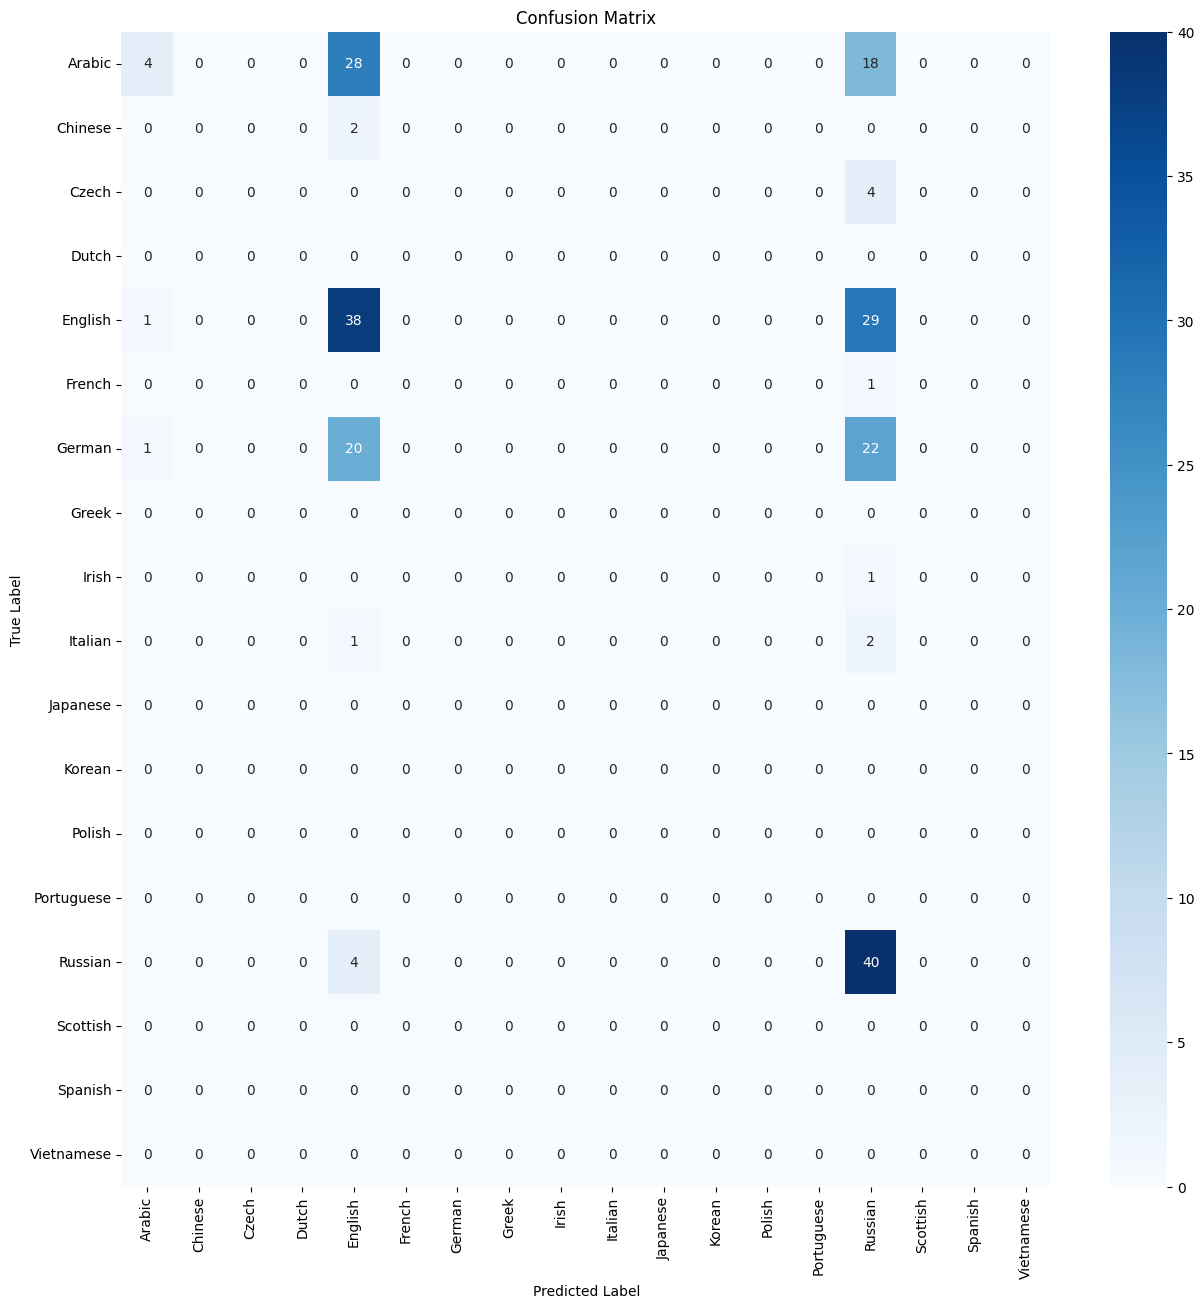

In [50]:
CLASS_LABELS = ["Arabic", "Chinese", "Czech", "Dutch", "English", "French", "German", "Greek", "Irish",
                "Italian", "Japanese", "Korean", "Polish", "Portuguese", "Russian", "Scottish", "Spanish", "Vietnamese"]

conf_mat = compute_confusion_matrix(X_val, y_val, F, W)
plot_confusion_matrix(conf_mat, CLASS_LABELS)

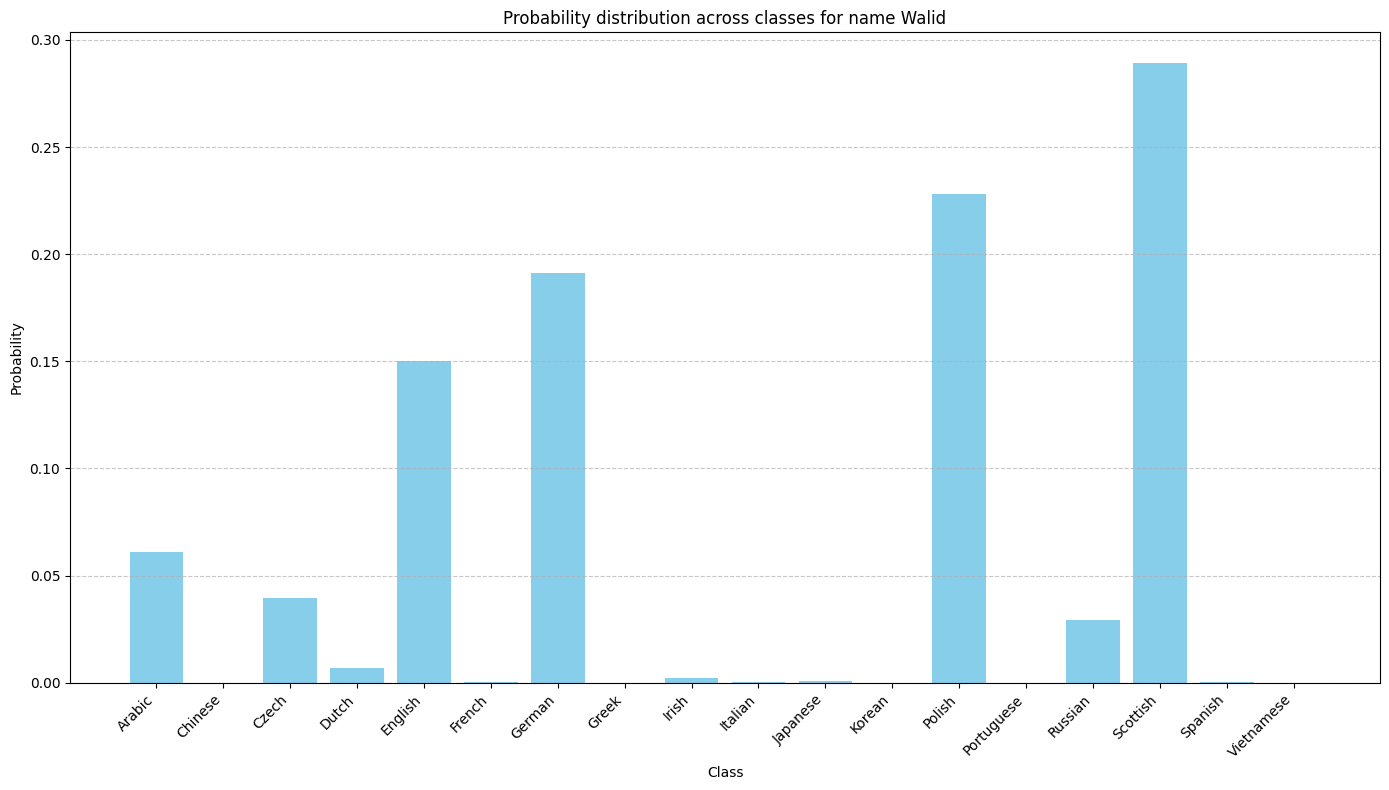

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Probability vector
probabilities = [0.012095016, 3.6008544e-07, 0.009391936, 0.00016826909, 0.0004116572, 0.00022118977, 0.00034874628, 1.5732709e-05, 0.00027897267, 0.00022437322, 0.9662762, 3.406003e-07, 0.00388105, 1.8484707e-08, 0.006659565, 1.4538011e-06, 2.5135929e-05, 4.377909e-09]

# Corresponding labels for the classes
labels = ["Arabic", "Chinese", "Czech", "Dutch", "English", "French", "German", "Greek", "Irish",
          "Italian", "Japanese", "Korean", "Polish", "Portuguese", "Russian", "Scottish", "Spanish", "Vietnamese"]

# Create an array with the positions of the bars along the x-axis
x_pos = np.arange(len(labels))

# Start a new plot
plt.figure(figsize=(14, 8))  # Width, height in inches

# Create bars
plt.bar(x_pos, probabilities, color='skyblue')

# Add title and labels
plt.title('Probability distribution across classes for name Keiichi')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(x_pos, labels, rotation=45, ha="right")  # Rotate labels to fit them well

# Optional: Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()